# The `Problem` class

An analytical problem is a problem where the mathematical formulation of the various objectives is known, as opposed to a data-driven problem, where one may need to train surrogate models to proceed with optimization.

The `Problem` class is the way to define optimization problems in the DESDEO framework. Once defined, the same `Problem` class instance can be used to solve optimization problems using various EAs from the `desdeo-emo` package, or the more traditional methods from the `desdeo-mcdm` package.

This notebook will help you understand how to instantiate a analytical problem object from scratch. The notebook will also go over other abstractions, namely classes for defining the decision variables, objectives, and the constraints, and will go over the functionalities provided by the abstractions.

## Multiobjective Optimization Problem

Let's say that we have the following minimization problem:

\begin{equation}
\begin{aligned}
& \underset{\mathbf x}{\text{min}}
& & y_1, y_2\\
& & & y_1 = x_1 + x_2 \\
& & & y_2 = x_1 / x_2 \\
& \text{s.t.} & &  2 \leq x_1 \leq 5 \\
& & &  1 \leq  x_2 \leq 10 \\
& & &  x_1 + x_2 \leq 10 \\
& & &  \mathbf{x} \; \in S, \\
\end{aligned}
\end{equation}


## Variables

Before instantiating the problem instance, we have to create object to define each of the variables, objectives, and constraints.

The variable objects can be created with the `desdeo_problem.Variable.Variable` class.
This object stores the information related to the variable (such as, lower bound, upper bound, and an initial value).
This information is used by the methods whenever required (such as when setting box constraints on searching algorithms or recombination operators) and for displaying results to the decision maker.
Use this class to create variable objects, one variable at a time.

To define multiple `Variable` instances easily, use the `desdeo_problem.Variable.variable_builder` function.
The function takes in all the necessary information for all the variables at once, and returns a List of `Variable` instances, one for each decision variable.

Use the `help()` function to know more about any function/class in the desdeo framework.

In [1]:
from desdeo_problem import variable_builder

help(variable_builder)

Help on function variable_builder in module desdeo_problem.problem.Variable:

variable_builder(names: List[str], initial_values: Union[List[float], numpy.ndarray], lower_bounds: Union[List[float], numpy.ndarray] = None, upper_bounds: Union[List[float], numpy.ndarray] = None) -> List[desdeo_problem.problem.Variable.Variable]
    Automatically build all variable objects.
    
    Arguments:
        names (List[str]): Names of the variables
        initial_values (np.ndarray): Initial values taken by the variables.
        lower_bounds (Union[List[float], np.ndarray], optional): Lower bounds of the
            variables. If None, it defaults to negative infinity. Defaults to None.
        upper_bounds (Union[List[float], np.ndarray], optional): Upper bounds of the
            variables. If None, it defaults to positive infinity. Defaults to None.
    
    Raises:
        VariableError: Lengths of the input arrays are different.
    
    Returns:
        List[Variable]: List of variable ob

Let's build the `Variable` objects

In [2]:
var_names = ["a", "b"]  #  Make sure that the variable names are meaningful to you.

initial_values = [3, 3]  #  Some (but not all) methods require intial values for the decision variables.
lower_bounds = [2, 1]  #  The lower and upper bounds (also known as box constraints) can be handeled by the Variable object.
upper_bounds = [5, 10]

variables = variable_builder(var_names, initial_values, lower_bounds, upper_bounds)

In [3]:
print("Type of \"variables\": ", type(variables))
print("Length of \"variables\": ", len(variables))
print("Type of the contents of \"variables\": ", type(variables[0]))

Type of "variables":  <class 'list'>
Length of "variables":  2
Type of the contents of "variables":  <class 'desdeo_problem.problem.Variable.Variable'>


## Objectives

Objectives are defined using tha various objective classes found within the module `desdeo_problem.Objective`. To define an objective class instance, one needs to pass the following:

1. Objective name/s (Required): Name of the objective (or list of names, for multiple objective). This information will be used when displaying results to the user. Hence, these names must be understandable to the user.

2. Evaluator (Required for analytical/simulation based objectives): An evaluator is a python `Callable` which takes in the decision variables as it's input and returns the corresponding objective values. This python function can be used to connect to simulators outside the DESDEO framework.

3. Lower bound (Not required): A lower bound for the objective. This information can be used to generate approximate ideal/nadir point during optimization.

4. Upper bound (Not required): An upper bound for the objective. This information can be used to generate approximate ideal/nadir point during optimization.

5. maximize (Not required): This is a boolean value that determines whether an objective is to be maximized or minimized. This is `False` by default (i.e. the objective is minimized).

The DESDEO framework has the following classification for objectives, based on the kind of evaluater to be used:

1. "Scalar" objectives: If an evaluator/simulator evaluates only one objective, the objective is defined as a Scalar objective. Use the `desdeo_problem.Objective._ScalarObjective` class to handle such cases.

2. "Vector" objectives: If an evaluator evaluates and returns more than one objective at once, the set of objectives is defined as Vector objective. Use the `desdeo_problem.Objective.VectorObjective` class to handle such cases.

**Note**:`_ScalarObjective` will be depreciated in the future, and all of it's functionality will be handled by the `VectorObjective` class, which will be renamed to, simply, `Objective`.

To define a problem instance, the objectives may be defined as all Scalar objectives, all Vector objectives, or a mix of both, depending upon the case.

Let's see how to define and use both kinds of Objective classes:

In [4]:
from desdeo_problem import ScalarObjective, VectorObjective

import numpy as np

Define the evaluators for the objectives. These evaluators should be python functions that take in the decision variable values and give out the objective value/s. The arguments of these evaluators are **2-D Numpy arrays**.

In [5]:
# Sometimes individual objectives can be calculated independently.
# For example, below we define the two objectives in two different Python functions

def obj1(x):
    return x[:, 0] + x[:, 1]

def obj2(x):
    return x[:, 0] / x[:, 1]

In [6]:
# Sometimes two or more objectives are returned by the same method (for example, a simulator), and cannot be calculated independently.

def obj1_2(x):
    y1 = x[:, 0] + x[:, 1]
    y2 = x[:, 0] / x[:, 1]
    return (y1, y2)

Define the objectives. For this, you need the names of the objectives, and the evaluators defined above. If an evaluator returns multiple objective values, use the `VectorObjective` class to define those objectives. If an evaluator returns objective values for only one objective, either `VectorObjective` or `ScalarObjective` can be used.

If using `VectorObjective`, names should be provided in a list.

Additionaly, bounds of the objective values can also be provided.

In [7]:
obj_names = ["y1", "y2"]
f1 = ScalarObjective(obj_names[0], obj1)
f2 = ScalarObjective(obj_names[1], obj2)

# Or

f1_2 = VectorObjective(obj_names, obj1_2)

## Constraints

Constraint may depend on the decision variable values, as well as the objective function.

The constraint should be defined so that when evaluated it should return a positive value if the constraint is adhered to, and a negative value if the constraint is breached.

In [8]:
from desdeo_problem import ScalarConstraint

const_func = lambda x, y: 10 - (x[:, 0] + x[:, 1])

# Args: name, number of variables, number of objectives, callable

cons1 = ScalarConstraint("c_1", 2, 2, const_func)

In [9]:
# You can also define const_func as:
def const_func(x, y):
    return 10 - (x[:, 0] + x[:, 1])

# Note that the function takes a second input (the objective values) even if they are not used in the constraint.

## Creating the Problem object

Now that we have all the building blocks, we can create the problem object, using the `desdeo_problem.Problem.MOProblem` class.

Provide objectives, variables and constraints in lists.

In [10]:
from desdeo_problem import MOProblem

prob = MOProblem(objectives=[f1, f2], variables=variables, constraints=[cons1])

The problem class provides abstractions such as the `evaluate` method. The method evaluates all the objective and constraint values for a given set of decision variables (in a numpy array), using the evaluators.

The abstraction also provides methods such as `train` and `surrogate_evaluate` for data driven problem. These will be tackled in the next notebook.

The output is a NamedTuple object. It contains the following elements:

1. `objectives`: Contains the objective values

2. `fitness`: Contains the fitness values. Fitness is either equal to the objective value, or equal to (-1 * objective value), depending upon whether the objective is to be minimized or maximized respectively. The optimization methods in the DESDEO framework internally use this value, rather than the values contained in output.objectives

3. `constraints`: Contains constraint violation values.
4. `uncertainity`: Contains the quantification of "uncertainity" of the evaluation

All of these values can be accessed in different ways, as shown below.

**Note**: Input as list of lists is not supported

In [11]:
data = np.asarray([[2, 2], [5, 5]])
res= prob.evaluate(data)

In [12]:
print(res)

Evaluation Results Object 
Objective values are: 
[[ 4.  1.]
 [10.  1.]]
Constraint violation values are: 
[[6.]
 [0.]]
Fitness values are: 
[[ 4.  1.]
 [10.  1.]]
Uncertainity values are: 
[[nan nan]
 [nan nan]]



In [13]:
print("The objective values for the given set of decision variables are: \n", res.objectives)
print("The constraint violation for the given set of decision variables are:\n", res.constraints)

The objective values for the given set of decision variables are: 
 [[ 4.  1.]
 [10.  1.]]
The constraint violation for the given set of decision variables are:
 [[6.]
 [0.]]


In [14]:
res

EvaluationResults(objectives=array([[ 4.,  1.],
       [10.,  1.]]), fitness=array([[ 4.,  1.],
       [10.,  1.]]), constraints=array([[6.],
       [0.]]), uncertainity=array([[nan, nan],
       [nan, nan]]))

## Evaluating and visualizing some random inputs

In [15]:
import numpy as np

In [16]:
random_inputs = np.random.rand(100,2)
random_inputs = random_inputs * (
    np.array(upper_bounds) - np.array(lower_bounds)
) + lower_bounds

In [17]:
random_results = prob.evaluate(random_inputs)

In [18]:
import matplotlib.pyplot as plt

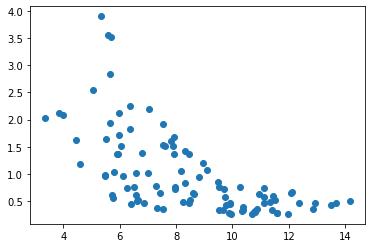

In [19]:
plt.scatter(
    x=random_results.objectives[:,0],
    y=random_results.objectives[:,1]
)

In [20]:
# Finding non-dominated solutions

from desdeo_tools.utilities import non_dominated

In [21]:
non_dom_indices = non_dominated(random_results.objectives)

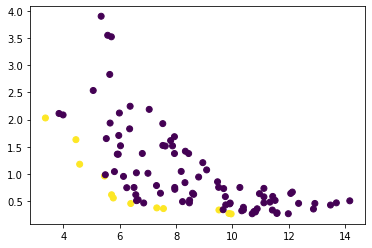

In [22]:
plt.scatter(
    x=random_results.objectives[:,0],
    y=random_results.objectives[:,1],
    c = non_dom_indices.astype(int)
)

## Saving results

In [23]:


import pandas as pd

results = pd.DataFrame(
    np.hstack((random_inputs, random_results.objectives, non_dom_indices.reshape(-1,1))),
    columns = [*var_names, *obj_names, "non_dominated"])

results

,a,b,y1,y2,non_dominated
0,4.409227,1.963184,6.372411,2.245957,0.0
1,2.796312,3.714097,6.510409,0.752891,0.0
2,4.351392,1.225601,5.576993,3.550414,0.0
3,4.898645,4.050301,8.948945,1.209452,0.0
4,2.950384,6.812177,9.762561,0.433104,0.0
...,...,...,...,...,...
95,3.328477,4.628283,7.956760,0.719160,0.0
96,3.433008,2.517666,5.950675,1.363568,0.0
97,3.559399,7.556243,11.115643,0.471054,0.0
98,2.230882,4.369755,6.600636,0.510528,0.0


In [24]:
results.to_csv("results.csv", index=False)